# Water Pump failure

In this Notebook we will analyse data from a water pump which experienced frequent failures in the period spring/summer 2018.

As input we have time series data from 52 sensors which measure different physical properties of the system (like temperature and pressure). We will try to extract the different working modes of the pump and highlight possible early warning signals of breakage.

As always, we will start with some (brief) exploratory analysis, with the aim of examining missing or redundant data.

In [66]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [67]:
for path, directories, files in os.walk('sensor_data/'):
    for filename in files:
        print(os.path.join(path, filename))

sensor_data/sensor.csv


Load the dataset.

In [68]:
data =  pd.read_csv("sensor_data/sensor.csv")

# Data exploration and cleaning

## Exploration

Let's have a first look at the data

In [69]:
data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


**Observations:**


---



*   Data has a timestamp column, so its probably a timeseries data
*   Sensors do not have names
*   Sensor values appears to have different ranges
*   There appears to be a redundant column named 'Unnamed: 0'

Lets look further into the data, this time looking more closely to the type of columns and their statistics



***Task 1:***

Look into the different columns of the data and identify if there are any defective sensors. 

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

**Observations:**


---



*   Timestamp column has string type
*   `sensors_15` does not have any values
*   There is some amount of missing data in almost all sensors 

In [71]:
data.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


**Observations:**


---



*   Sensors have different ranges, eg `sensor_00` has mean 2.3 and variance 0.4 while `sensor_04` has mean 590 and variance 144.
*   There are no negative values

***Task 2:***

Time of each event is recorded in the timestamp column. Since the format is string, create a new columns where time is registered as pandas timestamp object.

Also drop the `Unnamed: 0` column since it is just a row count.

In [72]:
# Let's convert the data type of timestamp column to datatime format
data['datetime'] = pd.to_datetime(data['timestamp'])
data.drop(['timestamp', 'Unnamed: 0'], axis=1, inplace=True)
data.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,datetime
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,2018-04-01 00:00:00
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,2018-04-01 00:01:00
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL,2018-04-01 00:02:00
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL,2018-04-01 00:03:00
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL,2018-04-01 00:04:00


## Cleaning

***Task 3:***

For each sensor, identify the percentage of missing data. Also check if there are any duplicated rows. Finally, remove the sensors having more than 3% of missing values.

In [73]:
perc_nans = data.isnull().sum().sort_values(ascending=False)*100/len(data)
perc_nans.head(10)

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
sensor_08      2.317992
sensor_06      2.177741
sensor_09      2.085603
sensor_01      0.167484
sensor_30      0.118464
dtype: float64

In [74]:
data.duplicated().value_counts()

False    220320
dtype: int64

In [75]:
data.drop(['sensor_15', 'sensor_50', 'sensor_51', 'sensor_00'], axis=1, inplace=True)

Lets now look at the label column. What are the labels and how are they distributed?

In [76]:
data['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

**Observations:**


---



*   There are three working status, but with very few observations in the `BROKEN` category

In [77]:
data.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,datetime
0,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:00:00
1,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,2018-04-01 00:01:00
2,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,NORMAL,2018-04-01 00:02:00
3,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,NORMAL,2018-04-01 00:03:00
4,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,NORMAL,2018-04-01 00:04:00


## Visualizations

***Task 4:***

Visualize the distribution of the individual sensor values with a histogram plot. There will be 48 sensors left at this stage, you can use a layout of (10, 5) ie, 10 rows each of 5 sensor's histogram plot. Make sure to have a large enough figure size.

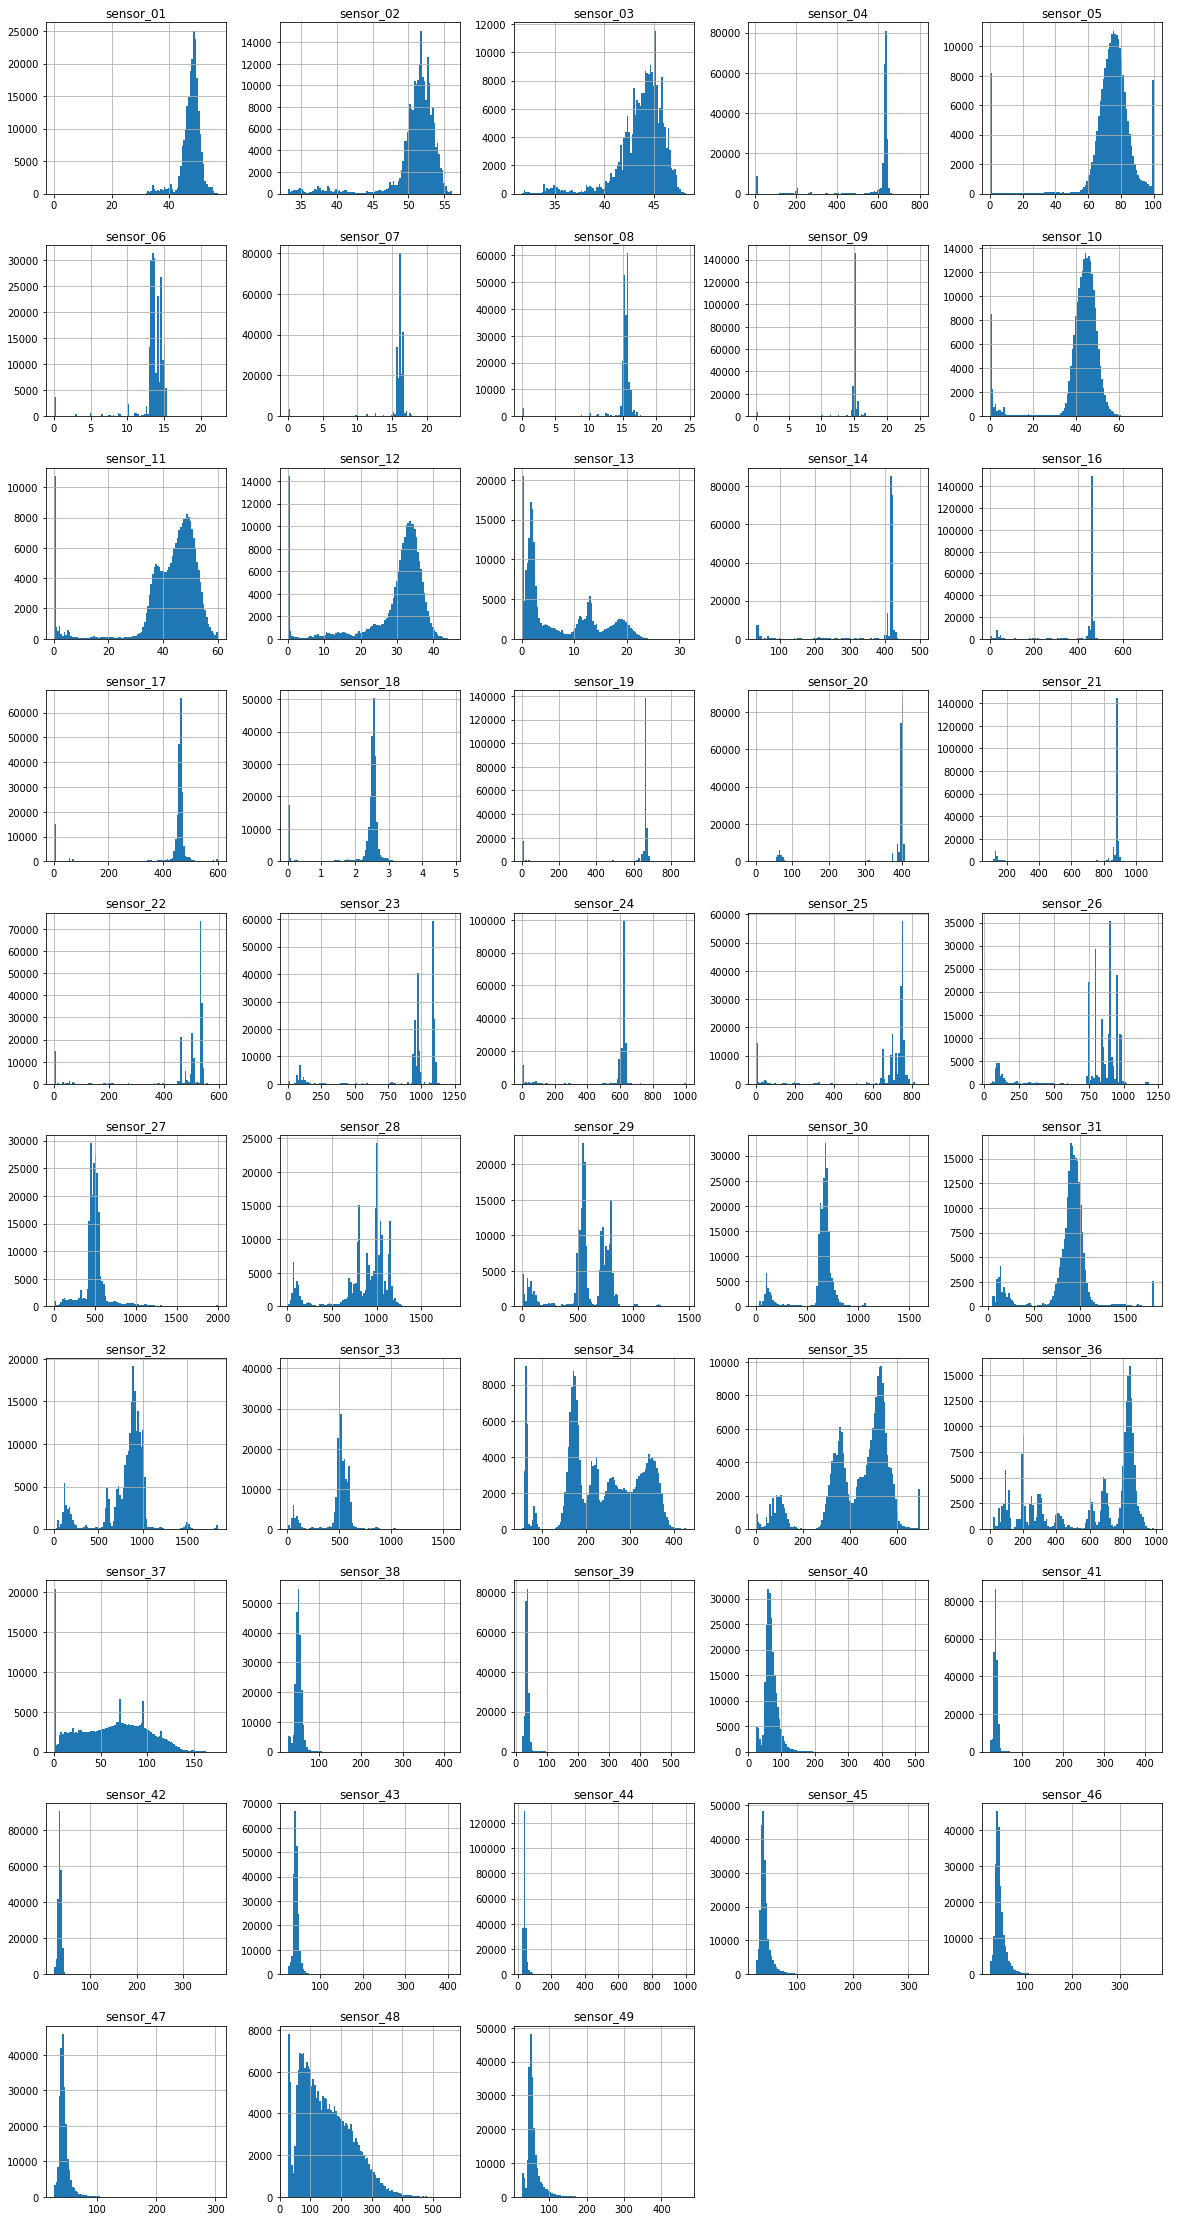

In [78]:
data.iloc[:, :48].hist(bins=100, figsize=(20,40), layout=(10,5))
plt.show()

**Observations:**


---



*   Most of the sensor values have a unimodal distribution, but there are also some multimodal distributed values.

Now we can plot the data along time and quickly analyse some of the patterns that appears when the machine is in different `machine_status`.

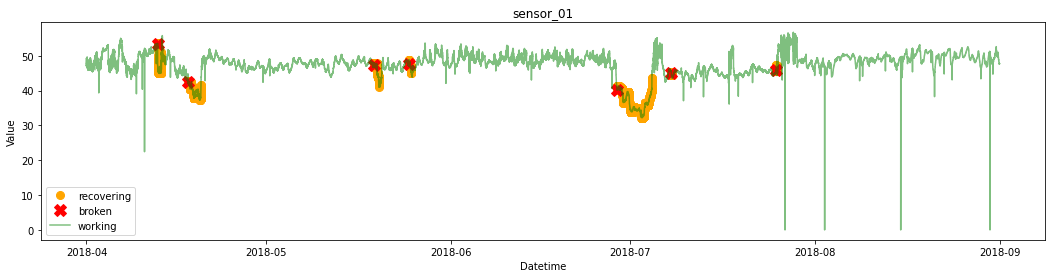

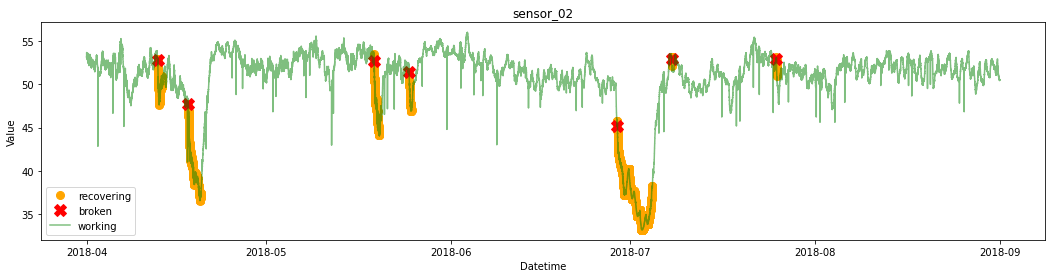

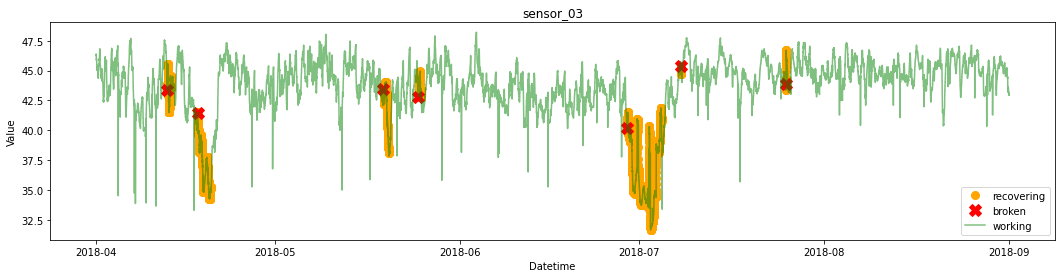

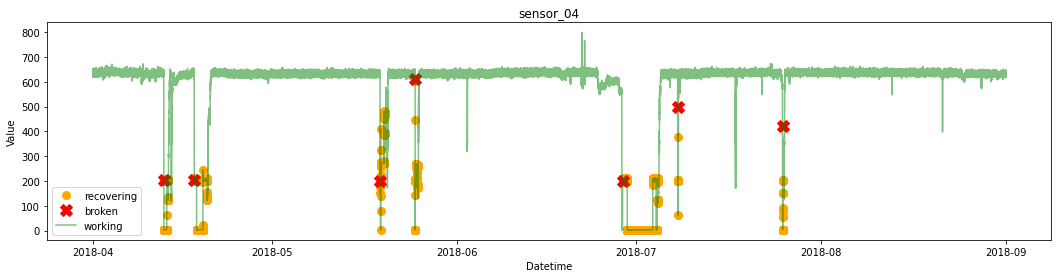

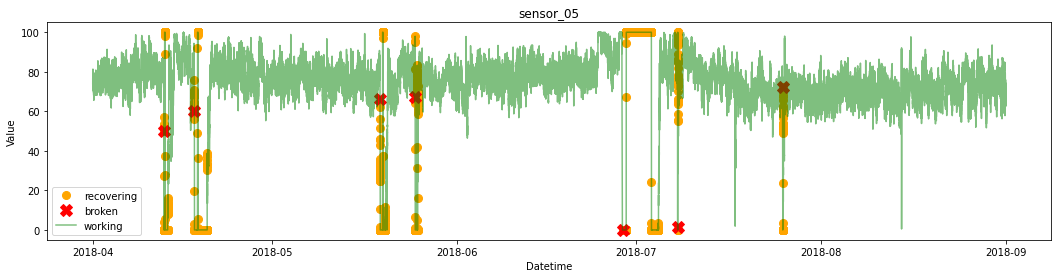

In [79]:
# Extract the readings from the BROKEN and RECOVERING states of the pump
broken = data[data['machine_status']=='BROKEN']
recovering = data[data['machine_status']=='RECOVERING']

sensors_to_plot = data.columns[:5]

# Plot time series for each sensor with BROKEN state marked with X in red color
for sensor_name in sensors_to_plot:
    plt.figure(figsize=(18, 4))
    # Plot time series for each sensor with RECOVERING state marked with 'O' in orange color
    plt.plot(recovering['datetime'], recovering[sensor_name], 
             linestyle='none', marker='o', color='orange', markersize=8, 
             label='recovering')
    # Plot time series for each sensor with BROKEN state marked with 'X' in red color
    plt.plot(broken['datetime'], broken[sensor_name], linestyle='none', 
             marker='X', color='red', markersize=12, label='broken')
    # Plot time series for each sensor (all status) in green line
    plt.plot(data['datetime'], data[sensor_name], color='green', 
             alpha=0.5, label='working')
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(sensor_name)
    plt.legend()
    plt.show()

**Observations:**

---

*   Although some of the sensors have anomalous behavious before the machine changes to `BROKEN` status, it would be difficult to write the rules for identifying potential failure



# K-means clustering and operating modes

Since we do not have enough data for supervised learning, we will explore the different working regimes of the pump with unsupervised learning. Let us try using Kmeans clustering

In [80]:
from sklearn.cluster import KMeans

***Task 5:***

Create `X_train`, a new dataframe which comprises only of sensor data (no labels, no timestamps). 

Then, rescale the sensor data so that they lay in a similar range. If we subtract the minimum across the column and divide by the maximum, all the values will be between 0 and 1.

Finally, since there are still sensors with missing data, fill these voids. Think about how you would want to fill the missing values of a time series data.

In [81]:
X_train = data.drop(['machine_status', 'datetime'], axis=1)
X_train = (X_train - X_train.min())/X_train.max()
X_train.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
0,0.830145,0.357862,0.304230,0.789471,0.764598,0.602081,0.683630,0.638146,0.602141,0.489146,...,0.091925,0.024164,0.025748,0.042702,0.013889,0.122855,0.066406,0.036225,0.234415,0.088474
1,0.830145,0.357862,0.304230,0.789471,0.764598,0.602081,0.683630,0.638146,0.602141,0.489146,...,0.091925,0.024164,0.025748,0.042702,0.013889,0.122855,0.066406,0.036225,0.234415,0.088474
2,0.834736,0.357862,0.306031,0.795114,0.735461,0.598179,0.679645,0.640226,0.600405,0.497561,...,0.089893,0.022924,0.025748,0.042065,0.013600,0.121951,0.067188,0.036225,0.230809,0.087227
3,0.830145,0.357087,0.306031,0.781659,0.769891,0.597854,0.688535,0.643494,0.603299,0.506916,...,0.094972,0.022924,0.025052,0.040153,0.013310,0.120145,0.067188,0.036225,0.230809,0.086604
4,0.830910,0.357862,0.306031,0.792075,0.765891,0.599480,0.687002,0.643494,0.603299,0.518868,...,0.104114,0.024164,0.025052,0.041428,0.013021,0.121048,0.068750,0.038132,0.234930,0.085981


We now want to fill the missing values for each column. To fill time series missing values, we can use pandas ffill which forward fills the missing values.

In [82]:
X_train.fillna(method='ffill', inplace=True)

**Elbow method**

The elbow method is a heuristic method to decide how many clusters to use for kmeans clustering. 

***Task 6:***

Calculate the inertia of the KMeans clustering method for clusters ranging from 1 to 15 and plot the results. What is an optimum number of clusters for this data?

In [83]:
inertia = []
 
for k in range(1, 15):
    # Building and fitting the model with k clusters
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    inertia.append(kmeanModel.inertia_)

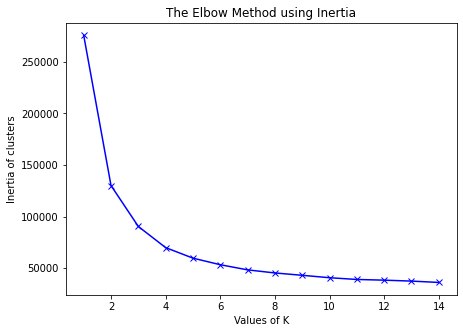

In [84]:
K = range(1, 15)
plt.figure(figsize=(7,5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia of clusters')
plt.title('The Elbow Method using Inertia')
plt.show()

**Observations:**

---

*   Clusters of size 4 or 5 seems to be the optimum

Let us now fit the model with 5 clusters to the data.

In [85]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train)
labels = kmeans.predict(X_train)

data['cluster'] = labels

We can also see the number of points assigned to each cluster

In [86]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)
for n in range(5):
  print(f"Cluster {unique_elements[n]} \n  Points {counts_elements[n]}")

Cluster 0 
  Points 54177
Cluster 1 
  Points 23588
Cluster 2 
  Points 51623
Cluster 3 
  Points 16542
Cluster 4 
  Points 74390


Assigning different colours to different clusters and visualizing the sensor data belonging to the clusters.

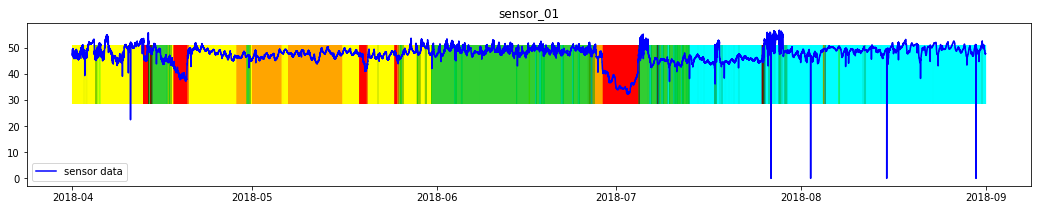

In [90]:
colors = ['limegreen', 'orange', 'yellow', 'red', 'cyan']
colors_plot = [colors[i] for i in data['cluster'].values]

sensors_to_plot = ['sensor_01']
for sensor_name in sensors_to_plot:
    plt.figure(figsize=(18,3))
    lower_limit = 0.5*data[sensor_name].max() 
    upper_limit = 0.9*data[sensor_name].max()

    plt.plot(data['datetime'], data[sensor_name], color='blue', 
             label='sensor data')
    plt.vlines(data['datetime'], lower_limit, upper_limit, 
               color=colors_plot, alpha=0.01)
    plt.title(sensor_name)
    plt.legend()
    plt.show()

In order to get an idea if the learned clusters has captured the working modes of the machine. Find out which

In [88]:
broken = data[data['machine_status']=='BROKEN']
recovering = data[data['machine_status']=='RECOVERING']
normal = data[data['machine_status']=='NORMAL']

print(f"Broken: \n{broken['cluster'].value_counts()}\n")
print(f"Recovering: \n{recovering['cluster'].value_counts()}\n")
print(f"Normal: \n{normal['cluster'].value_counts()}\n")

Broken: 
2    3
3    2
1    1
4    1
Name: cluster, dtype: int64

Recovering: 
3    14336
1       78
0       34
2       24
4        5
Name: cluster, dtype: int64

Normal: 
4    74384
0    54143
2    51596
1    23509
3     2204
Name: cluster, dtype: int64



**Observations:**

---

*   The RECOVERING mode is captured well as one cluster
*   Since the BROKEN mode has too little data points, the cluster distribution does not provide more information
*   The NORMAL mode appears to be spread in the rest of 4 clusters

## Cluster visualisation

***Task 7:***

We can use t-SNE to project the clusters onto 2d and plot them, to have a rough idea of their geometrical relationships.
Select every 500th data point from the dataset and plot the t-SNE embeddings as a scatter plot with colour coding of the clusters

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


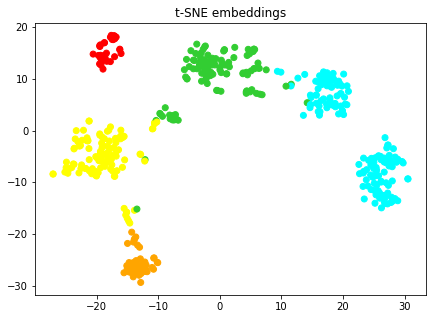

In [91]:
from sklearn.manifold import TSNE

subsampling_step = 500
X_subset = X_train.loc[::subsampling_step]
colors_plot = [colors[i] for i in data['cluster'].loc[::subsampling_step]]

X_embedded = TSNE(random_state=42).fit_transform(X_subset)

plt.figure(figsize=(7,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1], color=colors_plot)
plt.title("t-SNE embeddings")
plt.show()